In [34]:
import pandas as pd
import numpy as np


In [35]:
df=pd.read_csv("/kaggle/input/correct/labels.csv")

In [36]:
df.head()

,image_name,lables
0,1.jpg,0
1,2.jpg,0
2,3.jpg,0
3,IMG_20240805_131928561_HDR.jpg,0
4,IMG_20240805_131930233.jpg,0


In [37]:
!pip install -q tensorflowjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [38]:
import pandas as pd
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization, Input, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import tensorflowjs as tfjs
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil

In [39]:
# Read in Y labels from CSV

label_csv = '/kaggle/input/correct/labels.csv'
df_Y = pd.read_csv(label_csv)

In [40]:
# Read images and write with label to arrays

images_path = "/kaggle/input/hahahhahahahhaha/img"
images = []
labels = []
image_files = os.listdir(images_path)
image_files.sort()

for image_path in image_files:
    image = cv.imread(os.path.join(images_path, image_path)).astype('float32') # Read image as a float32 object
    image = cv.resize(image, (64, 64)) # Resize to smaller size for faster train time
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Convert to greyscale for faster train time
    image /= 255.0 # Normalise data
    
    label_index = (image_path) # Get index into df_Y
    print(label_index)
    label = df_Y[df_Y['image_name'] == label_index].lables.values[0] # Get label value
    
    # Write into arrays
    images.append(image)
    labels.append(label)

1.jpg
2.jpg
3.jpg
IMG_20240805_131928561_HDR.jpg
IMG_20240805_131930233.jpg
IMG_20240805_131931873_HDR.jpg
IMG_20240805_131933222_HDR.jpg
IMG_20240805_131935078_HDR.jpg
IMG_20240805_131937339.jpg
IMG_20240805_131938439.jpg
IMG_20240805_131939729.jpg
IMG_20240805_131940417.jpg
IMG_20240805_131941186_HDR.jpg
IMG_20240805_131942187_HDR.jpg
IMG_20240805_131943045_HDR.jpg
IMG_20240805_131944427_HDR.jpg
IMG_20240805_131945347_HDR.jpg
IMG_20240805_131948087_HDR.jpg
IMG_20240805_131950908_HDR.jpg
IMG_20240805_131952292_HDR.jpg
IMG_20240805_131953756_HDR.jpg
IMG_20240805_131955993_HDR.jpg
IMG_20240805_132028280_HDR.jpg
IMG_20240805_132030965_HDR.jpg
IMG_20240805_132034472_HDR.jpg
IMG_20240805_132035619_HDR.jpg
IMG_20240805_132037094_HDR.jpg
IMG_20240805_132040249_HDR.jpg
IMG_20240805_132043103_HDR.jpg
IMG_20240805_132044770_HDR.jpg
IMG_20240805_132046492_HDR.jpg
IMG_20240805_132048320_HDR.jpg
IMG_20240805_132049672_HDR.jpg
IMG_20240805_132050625_HDR.jpg
IMG_20240805_132052827_HDR.jpg
IMG_202408

In [41]:
# Convert to np arrays

images = np.array(images)
labels = np.array(labels)

# Let us visualise the count for each class

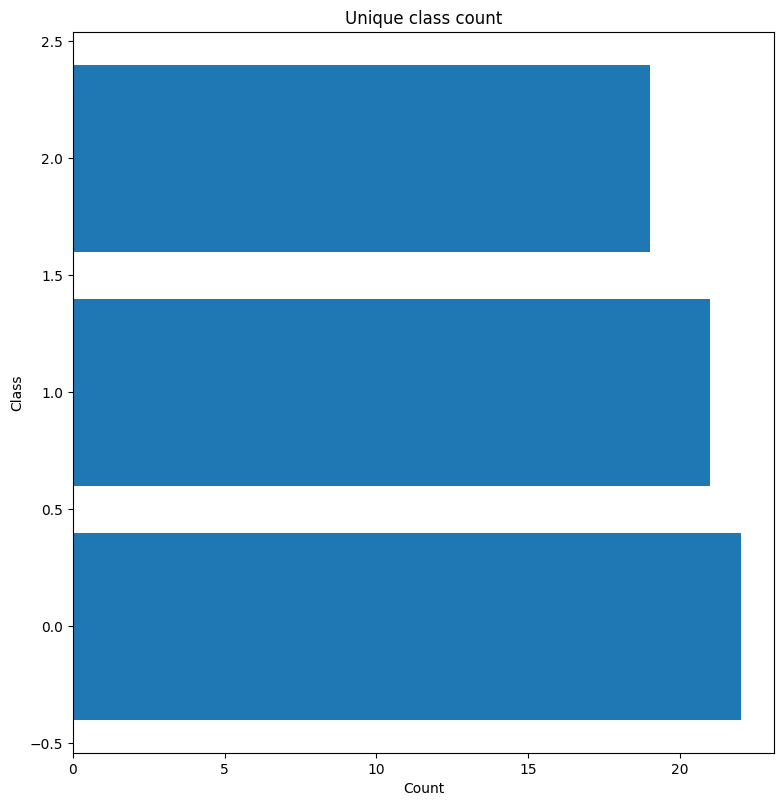

In [42]:
unique_class, class_count = np.unique(labels, return_counts=True)

plt.figure(figsize=(8,8))
plt.barh(unique_class, class_count)
plt.tight_layout(pad=2.0)
plt.title("Unique class count")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()

# Add greyscale dimension for cnn

In [43]:
images = np.expand_dims(images, axis=-1) 

# One hot encode the labels

In [44]:
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [45]:

decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]

# Plot 9 random images for visualisation

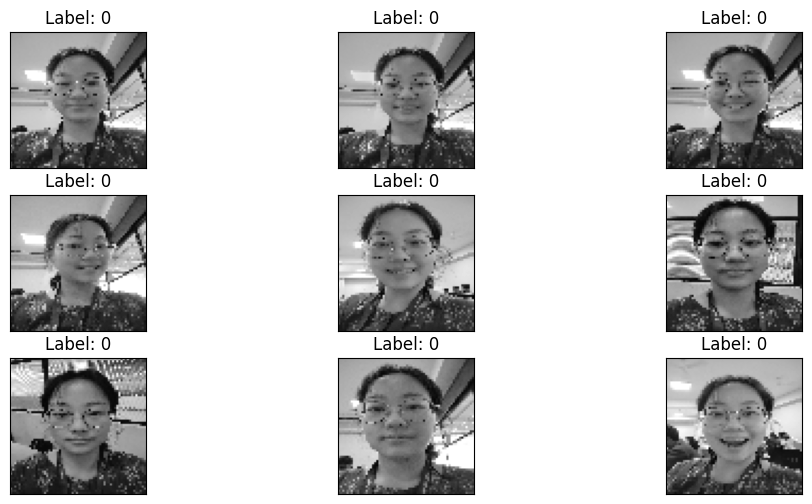

In [46]:
def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")
        
display_images(3, 3, images, labels, decoder)

# Randomly shuffle of the data

In [47]:
images, labels = shuffle(images, labels, random_state=0)

# Split the data into train, test and validation sets (70, 15, 15)

In [48]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

# Define augmentation generator for data augmentation

In [49]:
datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range= 0.2, 
    shear_range=0.2,               
    fill_mode='nearest',        
)

In [50]:
# Load augmented data into arrays

augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

for i in range(len(X_train)):
    image_expanded = np.expand_dims(X_train[i], axis=0)  
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    augmented_arr_X.extend(augmented_images)  
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation) 

In [51]:
# Set augmented data up for training

X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [52]:
# Shuffle again

X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

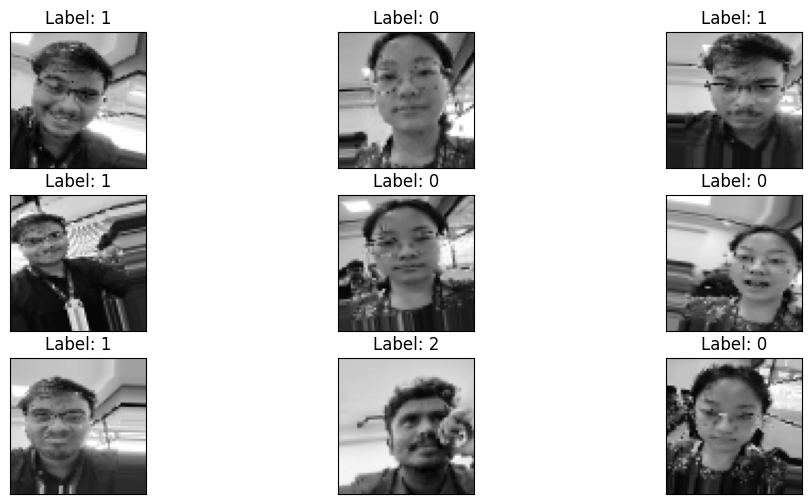

In [53]:
# Display augmented images

display_images(3, 3, X_train, Y_train, decoder)

In [54]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(512, (5, 5), activation='leaky_relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='leaky_relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(1024, activation='relu'),
    
    Dense(512, activation='relu'),
    Dropout(0.1),
    
    Dense(256, activation='sigmoid'),
    
    Dense(3, activation='softmax')
])

In [55]:
# Visualise model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 60, 60, 512)       13312     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 512)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 256)       1179904   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 256)       590080    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 256)        

In [56]:
# Compile and train the model

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_val,Y_val))

Epoch 1/10
14/14 [==============================] - 3s 44ms/step - loss: 1.1647 - accuracy: 0.3907 - val_loss: 1.0953 - val_accuracy: 0.5556
Epoch 2/10
14/14 [==============================] - 0s 25ms/step - loss: 1.0960 - accuracy: 0.3814 - val_loss: 1.1749 - val_accuracy: 0.2222
Epoch 3/10
14/14 [==============================] - 0s 24ms/step - loss: 1.1000 - accuracy: 0.3581 - val_loss: 1.1580 - val_accuracy: 0.2222
Epoch 4/10
14/14 [==============================] - 0s 25ms/step - loss: 1.0766 - accuracy: 0.4047 - val_loss: 1.3894 - val_accuracy: 0.3333
Epoch 5/10
14/14 [==============================] - 0s 24ms/step - loss: 1.0594 - accuracy: 0.4465 - val_loss: 1.1860 - val_accuracy: 0.2222
Epoch 6/10
14/14 [==============================] - 0s 25ms/step - loss: 0.8835 - accuracy: 0.5721 - val_loss: 0.7820 - val_accuracy: 0.5556
Epoch 7/10
14/14 [==============================] - 0s 25ms/step - loss: 0.6555 - accuracy: 0.7349 - val_loss: 0.3088 - val_accuracy: 0.7778
Epoch 8/10
14

In [57]:
# Train and validation accuracy

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

[]

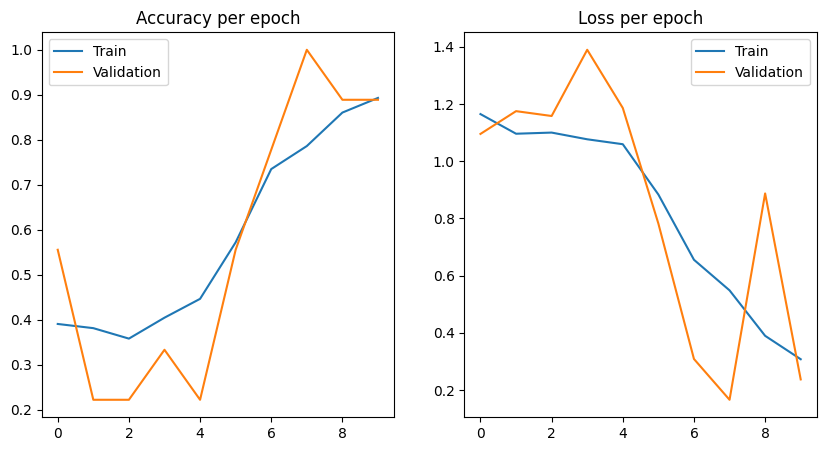

In [58]:
# Plot the accuracy and loss

_, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))

# Plot accuracy
axes[0].plot(train_accuracy)
axes[0].plot(validation_accuracy)
axes[0].legend(['Train', 'Validation'])
axes[0].set_title("Accuracy per epoch")

# Plot loss
axes[1].plot(train_loss)
axes[1].plot(validation_loss)
axes[1].legend(['Train', 'Validation'])
axes[1].set_title("Loss per epoch")

plt.plot()

In [59]:
# Get test predictions

Y_pred = model.predict(X_test)

1/1 [==============================] - 0s 94ms/step


In [60]:
# Find accuracy of the model

y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8000


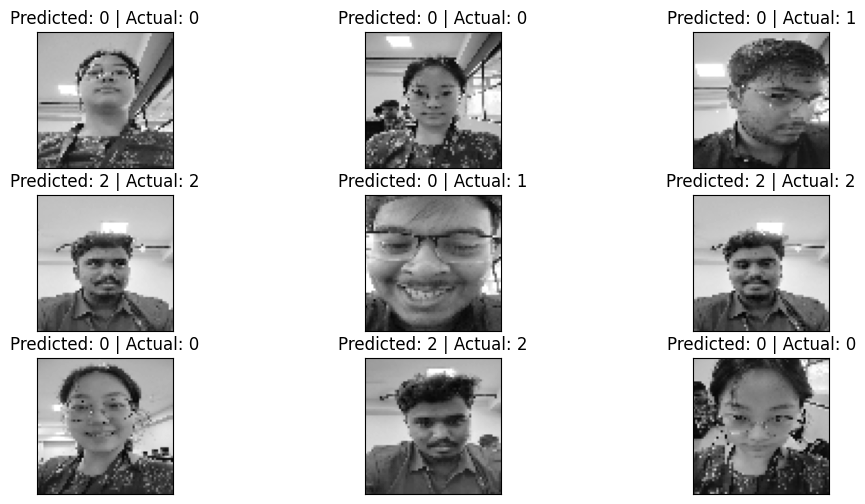

In [61]:
_, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Predicted: {decoder[y_pred_classes[i]]} | Actual: {decoder[y_true[i]]}")

In [ ]:
model.save('face_recognition_model.h5')

# Precision Recall and F1 SCORE

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1-score: {f1:.4f}')

report = classification_report(y_true, y_pred_classes)
print(report)


Accuracy: 0.8000
Precision: 0.6571
Recall: 0.8000
F1-score: 0.7167
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         3

    accuracy                           0.80        10
   macro avg       0.57      0.67      0.61        10
weighted avg       0.66      0.80      0.72        10



# CONFUSION MATRIX FOR TESTING DATA

Confusion Matrix:
[[5 0 0]
 [2 0 0]
 [0 0 3]]


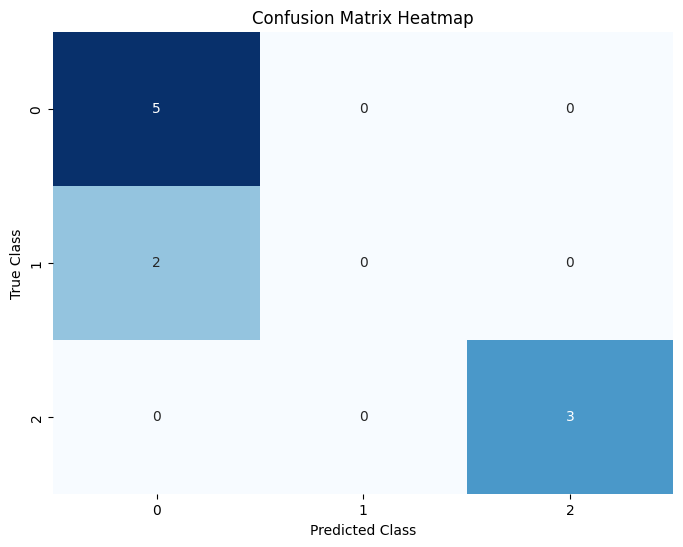

In [68]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
